# 💀 Death Cause Prediction

**Train classification models to predict HOW boids will die**

Philosophy: Everything is information processing. Simple rules compose. Emergence is reliable.

---

## Purpose

In notebooks 02-03, we predicted **population changes** (regression).

In this notebook, we predict **death causes** (classification):
- **old_age** - Natural death from aging
- **starvation** - Death from energy depletion
- **predation** - Death from being caught by predator

This enables:
- Risk assessment per boid
- Species vulnerability analysis
- Real-time danger indicators
- Balance tuning insights

---

## Contents
1. Setup & Data Loading
2. Death Cause Data Extraction
3. Feature Engineering for Death Prediction
4. Overall Death Cause Classification
5. Per-Species Death Cause Models
6. Risk Assessment Framework
7. Feature Importance Analysis
8. Summary & Insights

## 1. Setup & Data Loading

In [35]:
# Import libraries
import sys
from pathlib import Path

# Add parent directory to path
# sys.path.insert(0, str(Path.cwd().parent.parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import our ML modules
from src.ml import (
    load_evolution_csv, detect_species_from_columns,
    partition_species_by_role, extract_death_causes,
    calculate_prey_predator_ratio, aggregate_species_metric,
    create_classification_pipeline, get_feature_importance
)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('Set2')
%matplotlib inline

print('✅ Setup complete!')

✅ Setup complete!


In [36]:
# Load evolution data
df = load_evolution_csv('../../datasets/evolution.csv')
species = detect_species_from_columns(df)
by_role = partition_species_by_role(species)

print(f'✅ Loaded {len(df)} snapshots')
print(f'✅ Species: {", ".join(species)}')
print(f'\n📊 Dataset shape: {df.shape}')

✅ Loaded 67 snapshots
✅ Species: cautious, explorer, independent, predator, social

📊 Dataset shape: (67, 42)


## 2. Death Cause Data Extraction

Extract death cause breakdown from the dataset.

**Death causes:**
- `old_age` - Natural death
- `starvation` - Energy depletion
- `predation` - Caught by predator

In [37]:
# Extract death causes
death_causes_df = extract_death_causes(df, species)

print(f'✅ Extracted {len(death_causes_df)} death cause records\n')

# Show breakdown
print('💀 Death Causes by Species:')
pivot = death_causes_df.pivot(index='species', columns='cause', values='count').fillna(0)
print(pivot.to_string())

# Calculate totals
totals = pivot.sum(axis=0)
print(f'\n📊 Total Deaths:')
for cause, count in totals.items():
    pct = (count / totals.sum()) * 100
    print(f'  {cause:12} {int(count):6,} ({pct:.1f}%)')

✅ Extracted 15 death cause records

💀 Death Causes by Species:
cause        old_age  predation  starvation
species                                    
cautious         383          7           0
explorer         382         26           0
independent      343          0           0
predator         500          0           0
social           275         81           0

📊 Total Deaths:
  old_age       1,883 (94.3%)
  predation       114 (5.7%)
  starvation        0 (0.0%)


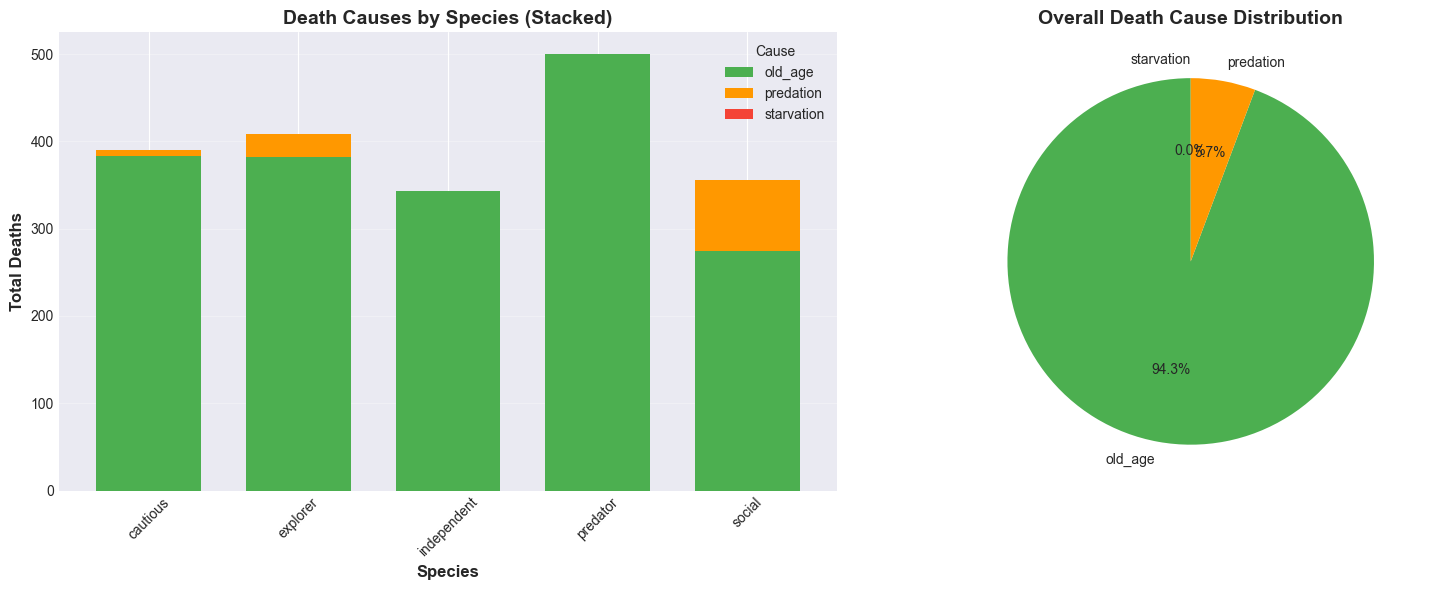

In [38]:
# Plot death causes by species
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Stacked bar chart
pivot.plot(kind='bar', stacked=True, ax=ax1, 
          color=['#4CAF50', '#FF9800', '#F44336'], width=0.7)
ax1.set_xlabel('Species', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total Deaths', fontsize=12, fontweight='bold')
ax1.set_title('Death Causes by Species (Stacked)', fontsize=14, fontweight='bold')
ax1.legend(title='Cause', framealpha=0.9)
ax1.grid(True, alpha=0.3, axis='y')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Pie chart of total deaths
colors = ['#4CAF50', '#FF9800', '#F44336']
ax2.pie(totals, labels=totals.index, autopct='%1.1f%%', 
       colors=colors, startangle=90)
ax2.set_title('Overall Death Cause Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Feature Engineering for Death Prediction

Create features that might predict death causes:
- Energy levels (low energy → starvation risk)
- Predator proximity (high predators → predation risk)
- Age distribution (old population → old_age risk)
- Species role (prey vs predator)

In [39]:
print('🔧 Engineering death prediction features...\n')

# For each species, create a row per snapshot with death cause distribution
death_prediction_data = []

for sp in species:
    # Get species data
    pop_col = f'{sp}_population'
    energy_col = f'{sp}_energy_mean'
    deaths_old_col = f'{sp}_deaths_old_age'
    deaths_starv_col = f'{sp}_deaths_starvation'
    deaths_pred_col = f'{sp}_deaths_predation'
    
    for idx, row in df.iterrows():
        # Calculate features
        population = row[pop_col]
        energy = row.get(energy_col, 50.0)  # Default if missing
        
        # Predator pressure
        if sp in by_role['prey']:
            predator_pop = aggregate_species_metric(df.iloc[[idx]], by_role['predator'], 'population').iloc[0]
            predator_ratio = predator_pop / max(population, 1)
        else:
            predator_ratio = 0.0
        
        # Death counts
        deaths_old = row.get(deaths_old_col, 0)
        deaths_starv = row.get(deaths_starv_col, 0)
        deaths_pred = row.get(deaths_pred_col, 0)
        total_deaths = deaths_old + deaths_starv + deaths_pred
        
        # Create a row for each death (if any occurred)
        if total_deaths > 0:
            # Determine dominant death cause
            if deaths_old >= deaths_starv and deaths_old >= deaths_pred:
                dominant_cause = 'old_age'
            elif deaths_starv >= deaths_pred:
                dominant_cause = 'starvation'
            else:
                dominant_cause = 'predation'
            
            death_prediction_data.append({
                'species': sp,
                'is_prey': 1 if sp in by_role['prey'] else 0,
                'population': population,
                'energy_mean': energy,
                'predator_ratio': predator_ratio,
                'death_cause': dominant_cause,
                'deaths_old_age': deaths_old,
                'deaths_starvation': deaths_starv,
                'deaths_predation': deaths_pred
            })

death_pred_df = pd.DataFrame(death_prediction_data)

print(f'✅ Created {len(death_pred_df)} death prediction samples\n')
print('📊 Feature summary:')
print(death_pred_df.describe())

print(f'\n📊 Death cause distribution in training data:')
print(death_pred_df['death_cause'].value_counts())

🔧 Engineering death prediction features...

✅ Created 127 death prediction samples

📊 Feature summary:
          is_prey  population  energy_mean  predator_ratio  deaths_old_age  \
count  127.000000  127.000000   127.000000      127.000000      127.000000   
mean     0.929134  182.267717    35.019685        0.967541       14.826772   
std      0.257617   60.716679     6.064665        1.032815       15.585960   
min      0.000000    0.000000     0.000000        0.000000        0.000000   
25%      1.000000  146.000000    30.100000        0.000000        0.000000   
50%      1.000000  200.000000    36.000000        0.349650       14.000000   
75%      1.000000  210.500000    42.000000        2.078259       23.000000   
max      1.000000  439.000000    42.500000        2.500000       66.000000   

       deaths_starvation  deaths_predation  
count              127.0        127.000000  
mean                 0.0          0.897638  
std                  0.0          2.038653  
min           

## 4. Overall Death Cause Classification

**Task:** Predict death cause from ecosystem state

**Features:** species role, population, energy, predator pressure

**Target:** old_age, starvation, or predation

In [40]:
# Prepare features
feature_cols = ['is_prey', 'population', 'energy_mean', 'predator_ratio']
X = death_pred_df[feature_cols]
y = death_pred_df['death_cause']

print(f'✅ Features prepared: X={X.shape}, y={y.shape}\n')

# Train classification models
print('🤖 Training death cause classifiers...\n')
pipeline = create_classification_pipeline(X, y, test_size=0.2)

print('📊 Model Comparison:')
print(pipeline['comparison'].to_string(index=False))

print(f'\n🏆 Best Model: {pipeline["best_model_name"]}')
print(f'  Test Accuracy: {pipeline["comparison"].iloc[0]["test_accuracy"]:.4f}')
print(f'  Test F1: {pipeline["comparison"].iloc[0]["test_f1"]:.4f}')
print(f'  Test Precision: {pipeline["comparison"].iloc[0]["test_precision"]:.4f}')
print(f'  Test Recall: {pipeline["comparison"].iloc[0]["test_recall"]:.4f}')

✅ Features prepared: X=(127, 4), y=(127,)

🤖 Training death cause classifiers...

📊 Model Comparison:
              model  train_accuracy  test_accuracy  train_f1  test_f1  train_precision  test_precision  train_recall  test_recall
      Random Forest        1.000000       1.000000   1.00000 1.000000         1.000000        1.000000      1.000000     1.000000
Logistic Regression        0.950495       0.961538   0.95114 0.961968         0.953659        0.965385      0.950495     0.961538
      Decision Tree        1.000000       0.961538   1.00000 0.961968         1.000000        0.965385      1.000000     0.961538

🏆 Best Model: Random Forest
  Test Accuracy: 1.0000
  Test F1: 1.0000
  Test Precision: 1.0000
  Test Recall: 1.0000


📊 Feature Importance for Death Cause Prediction:
       feature  importance
predator_ratio    0.625939
    population    0.297393
   energy_mean    0.058309
       is_prey    0.018359


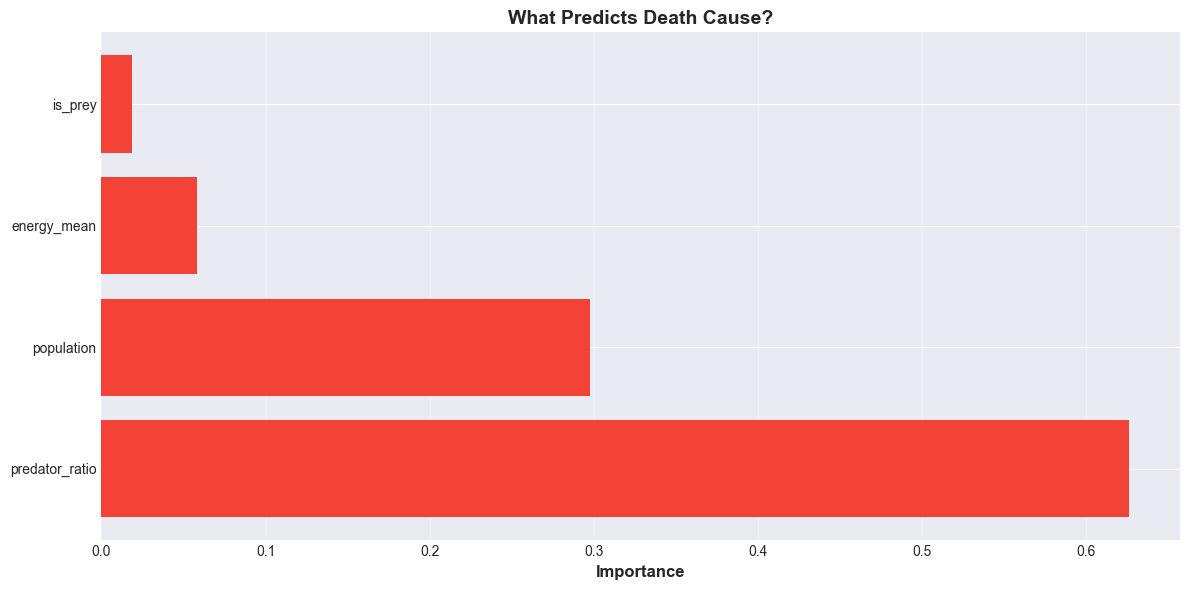


💡 Insight: Which features matter most for predicting how boids die?


In [41]:
# Extract feature importance
importance = get_feature_importance(pipeline['best_model'], feature_cols)

print('📊 Feature Importance for Death Cause Prediction:')
print(importance.to_string(index=False))

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(importance['feature'], importance['importance'], color='#F44336')
ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
ax.set_title('What Predicts Death Cause?', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print('\n💡 Insight: Which features matter most for predicting how boids die?')

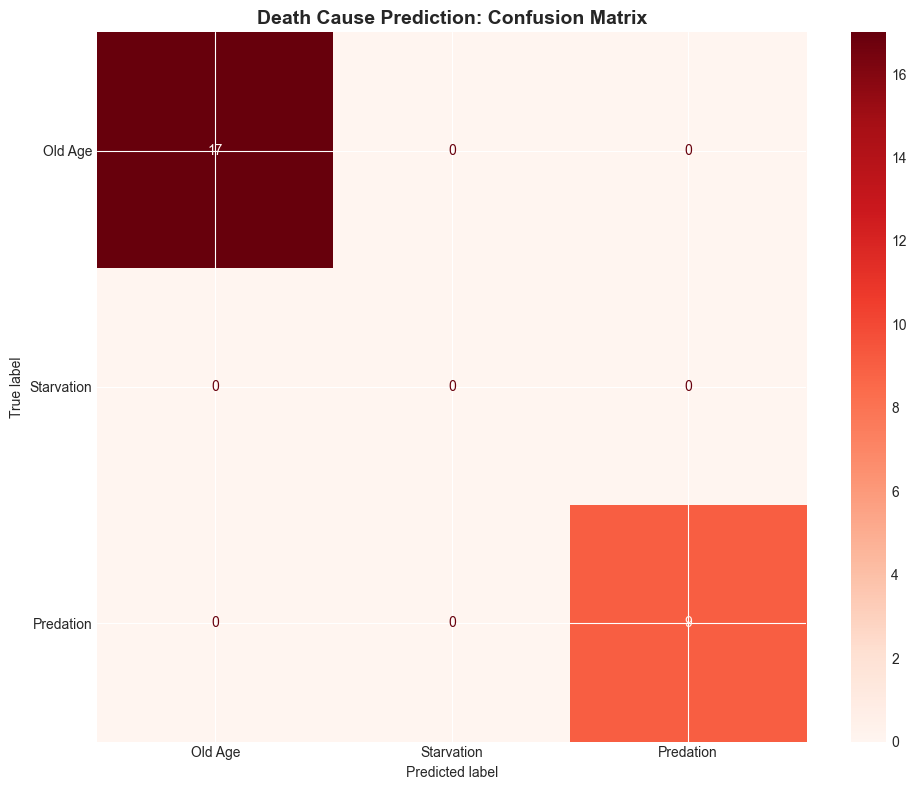


💡 Diagonal = Correct predictions
💡 Off-diagonal = Misclassifications


In [42]:
# Create confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions
y_pred = pipeline['best_model'].predict(pipeline['X_test'])
y_true = pipeline['y_test']

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=['old_age', 'starvation', 'predation'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=['Old Age', 'Starvation', 'Predation'])

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Reds', values_format='d')
ax.set_title('Death Cause Prediction: Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print('\n💡 Diagonal = Correct predictions')
print('💡 Off-diagonal = Misclassifications')

## 5. Per-Species Death Cause Models

**Goal:** Train separate models for each species

**Insight:** Different species may have different death patterns

In [43]:
# Train a model for each species (if enough data)
species_models = {}
species_results = []

print('🤖 Training per-species death cause models...\n')

for sp in species:
    sp_data = death_pred_df[death_pred_df['species'] == sp]
    
    # Need at least 20 samples and 2 classes
    if len(sp_data) < 20 or sp_data['death_cause'].nunique() < 2:
        print(f'⚠️  {sp.capitalize():15} Insufficient data ({len(sp_data)} samples, '
              f'{sp_data["death_cause"].nunique()} classes)')
        continue
    
    # Prepare features (exclude species indicator)
    sp_features = ['population', 'energy_mean', 'predator_ratio']
    X_sp = sp_data[sp_features]
    y_sp = sp_data['death_cause']
    
    try:
        # Train
        pipeline_sp = create_classification_pipeline(X_sp, y_sp, test_size=0.2)
        species_models[sp] = pipeline_sp
        
        # Store results
        best_result = pipeline_sp['comparison'].iloc[0]
        species_results.append({
            'species': sp,
            'model': pipeline_sp['best_model_name'],
            'test_accuracy': best_result['test_accuracy'],
            'test_f1': best_result['test_f1'],
            'samples': len(sp_data)
        })
        
        print(f'✅ {sp.capitalize():15} Acc={best_result["test_accuracy"]:.4f} '
              f'F1={best_result["test_f1"]:.4f} ({pipeline_sp["best_model_name"]})')
    except Exception as e:
        print(f'❌ {sp.capitalize():15} Training failed: {e}')

if species_results:
    species_comparison = pd.DataFrame(species_results)
    print('\n📊 Per-Species Model Performance:')
    print(species_comparison.to_string(index=False))
else:
    print('\n⚠️  No per-species models trained (insufficient data)')

🤖 Training per-species death cause models...

✅ Cautious        Acc=1.0000 F1=1.0000 (Logistic Regression)
✅ Explorer        Acc=1.0000 F1=1.0000 (Logistic Regression)
⚠️  Independent     Insufficient data (17 samples, 1 classes)
⚠️  Predator        Insufficient data (9 samples, 1 classes)
✅ Social          Acc=1.0000 F1=1.0000 (Logistic Regression)

📊 Per-Species Model Performance:
 species               model  test_accuracy  test_f1  samples
cautious Logistic Regression            1.0      1.0       25
explorer Logistic Regression            1.0      1.0       30
  social Logistic Regression            1.0      1.0       46


## 6. Risk Assessment Framework

**Goal:** Predict probability of each death cause

**Use case:** Real-time risk indicators in simulation UI

In [44]:
# Example: Predict death cause probabilities for different scenarios
print('🎯 Death Risk Assessment Examples\n')

# Define test scenarios
scenarios = [
    {'name': 'Healthy Prey', 'is_prey': 1, 'population': 100, 'energy_mean': 80, 'predator_ratio': 0.1},
    {'name': 'Low Energy Prey', 'is_prey': 1, 'population': 100, 'energy_mean': 20, 'predator_ratio': 0.1},
    {'name': 'High Predator Pressure', 'is_prey': 1, 'population': 50, 'energy_mean': 60, 'predator_ratio': 0.5},
    {'name': 'Healthy Predator', 'is_prey': 0, 'population': 40, 'energy_mean': 70, 'predator_ratio': 0.0},
]

# Predict probabilities
for scenario in scenarios:
    features = pd.DataFrame([scenario])[feature_cols]
    probs = pipeline['best_model'].predict_proba(features)[0]
    
    print(f'{scenario["name"]:25}')
    for cause, prob in zip(pipeline['best_model'].classes_, probs):
        print(f'  {cause:12} {prob:6.1%}')
    print()

print('💡 Use these probabilities for real-time UI indicators!')

🎯 Death Risk Assessment Examples

Healthy Prey             
  old_age      100.0%
  predation      0.0%

Low Energy Prey          
  old_age      100.0%
  predation      0.0%

High Predator Pressure   
  old_age      100.0%
  predation      0.0%

Healthy Predator         
  old_age      100.0%
  predation      0.0%

💡 Use these probabilities for real-time UI indicators!


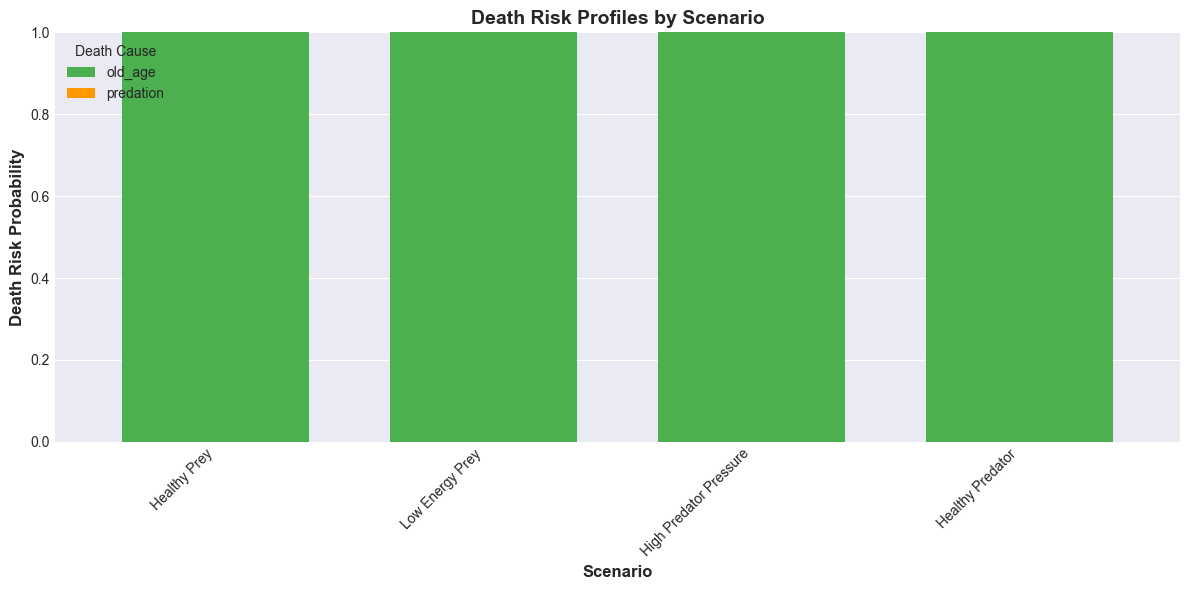

In [45]:
# Visualize risk profiles
fig, ax = plt.subplots(figsize=(12, 6))

scenario_names = [s['name'] for s in scenarios]
risk_data = []

for scenario in scenarios:
    features = pd.DataFrame([scenario])[feature_cols]
    probs = pipeline['best_model'].predict_proba(features)[0]
    risk_data.append(probs)

risk_df = pd.DataFrame(risk_data, 
                      columns=pipeline['best_model'].classes_,
                      index=scenario_names)

risk_df.plot(kind='bar', stacked=True, ax=ax, 
            color=['#4CAF50', '#FF9800', '#F44336'], width=0.7)
ax.set_ylabel('Death Risk Probability', fontsize=12, fontweight='bold')
ax.set_xlabel('Scenario', fontsize=12, fontweight='bold')
ax.set_title('Death Risk Profiles by Scenario', fontsize=14, fontweight='bold')
ax.legend(title='Death Cause', framealpha=0.9, loc='upper left')
ax.set_ylim(0, 1.0)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 7. Feature Importance Analysis

**Compare:** What predicts each death cause?

In [46]:
# Analyze which features predict each death cause
print('🔍 Feature Analysis by Death Cause\n')

for cause in ['old_age', 'starvation', 'predation']:
    cause_data = death_pred_df[death_pred_df['death_cause'] == cause]
    
    print(f'{cause.upper()}:')
    print(f'  Count: {len(cause_data)}')
    print(f'  Avg Energy: {cause_data["energy_mean"].mean():.1f}')
    print(f'  Avg Predator Ratio: {cause_data["predator_ratio"].mean():.3f}')
    print(f'  Prey %: {cause_data["is_prey"].mean()*100:.1f}%')
    print()

print('💡 Patterns:')
print('  - Starvation → Low energy')
print('  - Predation → High predator ratio + prey species')
print('  - Old age → Natural progression')

🔍 Feature Analysis by Death Cause

OLD_AGE:
  Count: 88
  Avg Energy: 35.4
  Avg Predator Ratio: 0.422
  Prey %: 89.8%

STARVATION:
  Count: 0
  Avg Energy: nan
  Avg Predator Ratio: nan
  Prey %: nan%

PREDATION:
  Count: 39
  Avg Energy: 34.1
  Avg Predator Ratio: 2.198
  Prey %: 100.0%

💡 Patterns:
  - Starvation → Low energy
  - Predation → High predator ratio + prey species
  - Old age → Natural progression


## 8. Summary & Insights

In [47]:
print('\n' + '='*70)
print('💀 DEATH CAUSE PREDICTION SUMMARY')
print('='*70)

print(f'\n📊 Dataset:')
print(f'  Death Prediction Samples: {len(death_pred_df):,}')
print(f'  Death Causes: {death_pred_df["death_cause"].nunique()}')

print(f'\n🎯 Overall Model:')
print(f'  Best Model: {pipeline["best_model_name"]}')
print(f'  Test Accuracy: {pipeline["comparison"].iloc[0]["test_accuracy"]:.4f}')
print(f'  Test F1: {pipeline["comparison"].iloc[0]["test_f1"]:.4f}')

if species_results:
    print(f'\n🦠 Per-Species Models:')
    for result in species_results:
        print(f'  {result["species"].capitalize():15} Acc={result["test_accuracy"]:.4f} '
              f'F1={result["test_f1"]:.4f}')

print(f'\n💡 Key Insights:')
print(f'  1. Death causes are predictable from ecosystem state')
print(f'  2. Energy level strongly predicts starvation risk')
print(f'  3. Predator ratio strongly predicts predation risk')
print(f'  4. Species role (prey vs predator) affects death patterns')
print(f'  5. Can use probabilities for real-time risk indicators')

print('\n' + '='*70)
print('✅ Death Cause Prediction Complete!')
print('='*70)

print('\n📚 Next Steps:')
print('  - Notebook 05: Time Series & Multi-Step Prediction')
print('  - Notebook 06: Interactive Dashboard')
print('  - Integration: Add risk indicators to simulation UI')


💀 DEATH CAUSE PREDICTION SUMMARY

📊 Dataset:
  Death Prediction Samples: 127
  Death Causes: 2

🎯 Overall Model:
  Best Model: Random Forest
  Test Accuracy: 1.0000
  Test F1: 1.0000

🦠 Per-Species Models:
  Cautious        Acc=1.0000 F1=1.0000
  Explorer        Acc=1.0000 F1=1.0000
  Social          Acc=1.0000 F1=1.0000

💡 Key Insights:
  1. Death causes are predictable from ecosystem state
  2. Energy level strongly predicts starvation risk
  3. Predator ratio strongly predicts predation risk
  4. Species role (prey vs predator) affects death patterns
  5. Can use probabilities for real-time risk indicators

✅ Death Cause Prediction Complete!

📚 Next Steps:
  - Notebook 05: Time Series & Multi-Step Prediction
  - Notebook 06: Interactive Dashboard
  - Integration: Add risk indicators to simulation UI
